# Marketing Optimization

### Goal: Identify clients for offers targeting to maximize revenue

## 1. Prepare Training Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets from sheets
social_demo = pd.read_csv("social_demo.csv")
product_holdings = pd.read_csv("product_holdings.csv")
financial_trans = pd.read_csv("financial_trans.csv")
sales_revenue = pd.read_csv("sales_revenue.csv")

In [3]:
# Merge datasets on ID column
data = (social_demo
        .merge(product_holdings, on="Client", how="left")
        .merge(financial_trans, on="Client", how="left")
        .merge(sales_revenue, on="Client", how="left"))

In [4]:
# Fill missing data from product_holdings and sales_revenue with 0
data.fillna(0, inplace=True)

In [5]:
# Note: Clients to be included in training set were the ones with sales_revenue data
# Used this fact for train-test split of merged data

# Add Dataset_Flag column based on sales_revenue presence
data['Flag'] = np.where(data['Client'].isin(sales_revenue['Client']), 'Train', 'Test')

# Separate train and test datasets using the flag
train_data = data[data['Flag'] == 'Train']
test_data = data[data['Flag'] == 'Test']

In [6]:
# Drop Flag column
train_data = train_data.drop(['Flag'],axis = 1)
test_data = test_data.drop(['Flag'],axis = 1)

## 2. Identify customer segments

In [7]:
# Aggregate revenue from all products
train_data['Total_Revenue'] = train_data[['Revenue_CL', 'Revenue_CC', 'Revenue_MF']].sum(axis=1)

In [8]:
# Identify homogeneous groups based on available features
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Pick features for segmentation
seg_features = ['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC',
            'ActBal_CL', 'VolumeCred', 'VolumeDeb', 'VolumeDebCash_Card', 
            'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsCred', 
            'TransactionsDeb', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card']

In [9]:
# check on quality of segmentation features
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)  # Remove features with <1% variance
significant_features = selector.fit_transform(train_data[seg_features])
print("Selected Features:", train_data[seg_features].columns[selector.get_support()])

Selected Features: Index(['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD',
       'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeDeb',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsCred', 'TransactionsDeb',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card'],
      dtype='object')


In [10]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Standardize features
scaler = StandardScaler()
X_segmentation = scaler.fit_transform(train_data[seg_features])

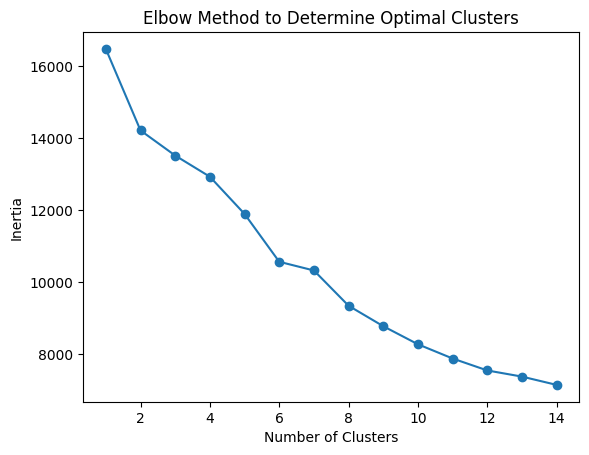

In [11]:
# Determine optimal number of clusters using the elbow method
inertia = []
cluster_range = range(1, 15)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_segmentation)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(cluster_range, inertia, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method to Determine Optimal Clusters")
plt.show()

In [12]:
# Apply K-Means Clustering
optimal_clusters = 6
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)  # 4 clusters as an example
train_data['Segment'] = kmeans.fit_predict(X_segmentation)

## 3. Analysis of identified groups

In [13]:
# Summarize cluster centers
segments = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=seg_features)
segments['Segment'] = segments.index
print("Cluster Centers:\n", segments)

Cluster Centers:
          Age      Tenure    ActBal_CA     ActBal_SA     ActBal_MF  ActBal_OVD  \
0  44.684211   90.368421  1276.191241    762.715846  6.939433e+02  223.867481   
1  59.531335   86.395095  1615.405694   3346.005308  3.288967e+03   40.619223   
2  42.715328  105.364964  4508.232377   3093.328472  7.150881e+03   91.072229   
3  29.220957  110.865604  2639.275601   3984.015524  3.856766e+03   12.148779   
4  29.000000   55.000000  1049.024643      0.000000  4.547474e-13    0.000000   
5  40.833333  116.166667  3553.690119  68019.271012  2.843391e+03    0.000000   

    ActBal_CC    ActBal_CL    VolumeCred     VolumeDeb  VolumeDebCash_Card  \
0   65.725188  9674.287218   2617.301748   2609.826880          289.285714   
1   25.292063   112.474301   1194.027247   1057.632633          201.430406   
2  120.858689   321.718441   3664.282865   3830.206543          514.724192   
3    7.633802    98.165840    831.613035    801.070934          188.746421   
4    0.000000     0.0000

In [14]:
# Calculate the average revenue per segment to identify high-revenue groups:
segment_revenues = train_data.groupby('Segment')['Total_Revenue'].mean().reset_index()
#segment_revenues.sort_values(by='Total_Revenue', ascending=False, inplace=True)
print(segment_revenues)

   Segment  Total_Revenue
0        0       7.887810
1        1       7.762419
2        2       8.403266
3        3       8.567817
4        4       0.000000
5        5      12.560476


/tmp/ipykernel_640669/2476152549.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segment', y='Total_Revenue', data=segment_revenues, palette='viridis')


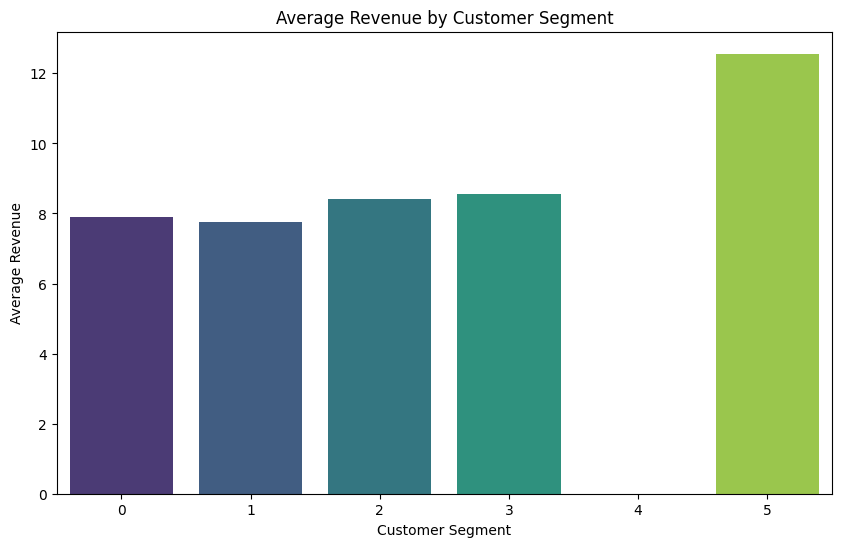

In [15]:
# visualize segments with the highest average revenue:
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y='Total_Revenue', data=segment_revenues, palette='viridis')
plt.title("Average Revenue by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Average Revenue")
plt.show()

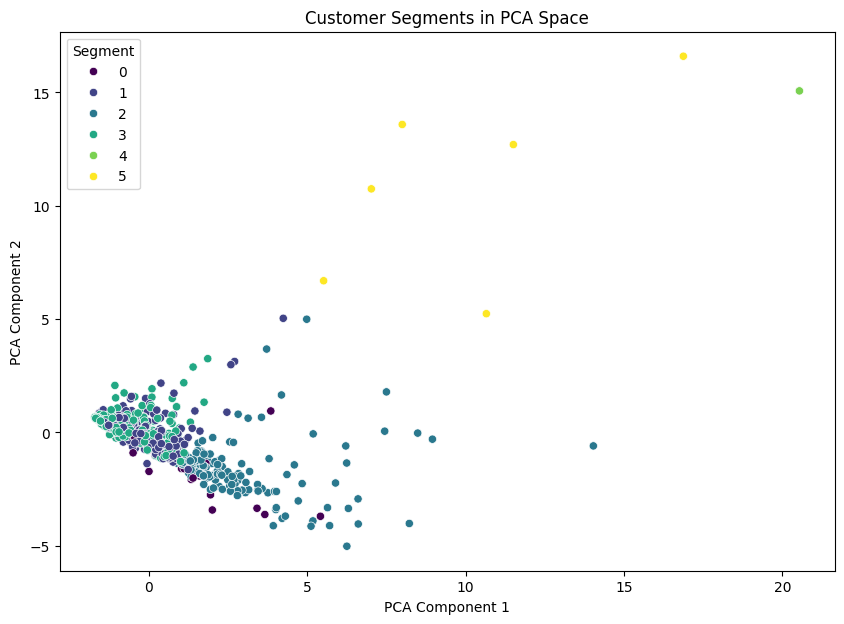

In [16]:
# check segment distributions
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_segmentation)
train_data['PCA1'] = X_pca[:, 0]
train_data['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Segment', data=train_data, palette='viridis')
plt.title("Customer Segments in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Segment")
plt.show()

In [17]:
# Drop additional columns
train_data = train_data.drop(['PCA1','PCA2'],axis = 1)

In [18]:
# Save datasets
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

<Figure size 1200x600 with 0 Axes>

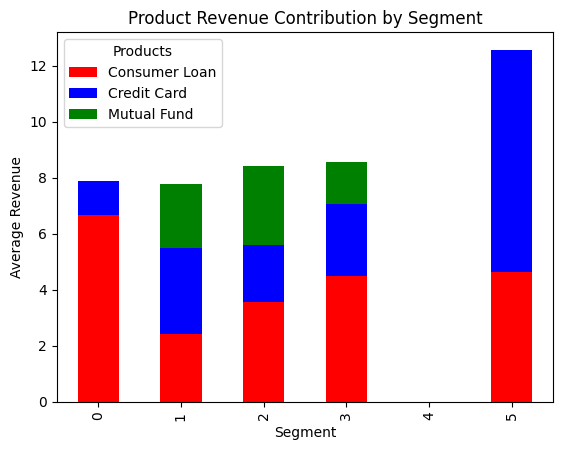

In [19]:
# revenue contributions from different products in each segment:
product_revenues = train_data.groupby('Segment')[['Revenue_CL', 'Revenue_CC', 'Revenue_MF']].mean().reset_index()

plt.figure(figsize=(12, 6))
product_revenues.plot(x='Segment', kind='bar', stacked=True, color=['red', 'blue', 'green'])
plt.title("Product Revenue Contribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Average Revenue")
plt.legend(['Consumer Loan', 'Credit Card', 'Mutual Fund'], title="Products")
plt.show()

## 4. Train Propensity Models

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score

In [21]:
# Define features and targets 

# Normalize numerical features
numerical_features = ['Age', 'Tenure', 'Count_CA', 'ActBal_CA', 'Count_SA', 'ActBal_SA', 
            'Count_MF', 'ActBal_MF', 'Count_OVD', 'ActBal_OVD', 'Count_CC', 'ActBal_CC',
            'Count_CL', 'ActBal_CL', 'VolumeCred', 'VolumeDeb', 'VolumeDebCash_Card', 
            'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsCred', 
            'TransactionsDeb', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card']
categorical_features = ['Sex']

# Preprocess features: normalize numerical and one-hot encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OrdinalEncoder(), categorical_features)
    ]
)

# object to string conversion
train_data['Sex'] = train_data['Sex'].astype('str')

# transform data for training model
X = train_data
X_scaled = preprocessor.fit_transform(X)

In [22]:
# Consumer Loan Propensity Model
y_cl = train_data['Sale_CL']
model_cl = LogisticRegression()
model_cl.fit(X_scaled, y_cl)
train_data['Prob_CL'] = model_cl.predict_proba(X_scaled)[:, 1]

# Credit Card Propensity Model
y_cc = train_data['Sale_CC']
model_cc = LogisticRegression()
model_cc.fit(X_scaled, y_cc)
train_data['Prob_CC'] = model_cc.predict_proba(X_scaled)[:, 1]

# Mutual Fund Propensity Model
y_mf = train_data['Sale_MF']
model_mf = LogisticRegression()
model_mf.fit(X_scaled, y_mf)
train_data['Prob_MF'] = model_mf.predict_proba(X_scaled)[:, 1]

In [23]:
# Validate models
for model, y, label in [(model_cl, y_cl, 'Consumer Loan'), 
                         (model_cc, y_cc, 'Credit Card'), 
                         (model_mf, y_mf, 'Mutual Fund')]:
    auc = roc_auc_score(y, model.predict_proba(X_scaled)[:, 1])
    print(f"{label} Model AUC: {auc}")

Consumer Loan Model AUC: 0.7148189528210858
Credit Card Model AUC: 0.6943512908249684
Mutual Fund Model AUC: 0.6903343838470168


In [24]:
model_features = ['Age', 'Sex', 'Tenure', 'Count_CA', 'ActBal_CA', 'Count_SA', 'ActBal_SA', 
            'Count_MF', 'ActBal_MF', 'Count_OVD', 'ActBal_OVD', 'Count_CC', 'ActBal_CC',
            'Count_CL', 'ActBal_CL', 'VolumeCred', 'VolumeDeb', 'VolumeDebCash_Card', 
            'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsCred', 
            'TransactionsDeb', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card']

In [25]:
# Consumer Loan model feature importance
importance_logistic = pd.DataFrame({"Feature": model_features, "Coefficient": model_cl.coef_[0]})
importance_logistic.sort_values(by="Coefficient", ascending=False, inplace=True)
print(importance_logistic)

                         Feature  Coefficient
15                    VolumeCred     1.163647
1                            Sex     0.424404
19        VolumeDeb_PaymentOrder     0.235446
21               TransactionsDeb     0.195709
2                         Tenure     0.183637
7                       Count_MF     0.170528
4                      ActBal_CA     0.145431
9                      Count_OVD     0.144959
6                      ActBal_SA     0.099542
13                      Count_CL     0.045908
12                     ActBal_CC     0.042229
17            VolumeDebCash_Card     0.004355
10                    ActBal_OVD    -0.004433
8                      ActBal_MF    -0.048066
16                     VolumeDeb    -0.051536
20              TransactionsCred    -0.053739
22      TransactionsDebCash_Card    -0.096981
18        VolumeDebCashless_Card    -0.103482
23  TransactionsDebCashless_Card    -0.149273
3                       Count_CA    -0.213827
5                       Count_SA  

In [26]:
# Credit Card model feature importance
importance_logistic = pd.DataFrame({"Feature": model_features, "Coefficient": model_cc.coef_[0]})
importance_logistic.sort_values(by="Coefficient", ascending=False, inplace=True)
print(importance_logistic)

                         Feature  Coefficient
15                    VolumeCred     0.575714
5                       Count_SA     0.563340
3                       Count_CA     0.404683
21               TransactionsDeb     0.353286
8                      ActBal_MF     0.197198
0                            Age     0.164272
18        VolumeDebCashless_Card     0.143497
4                      ActBal_CA     0.098083
1                            Sex     0.060554
17            VolumeDebCash_Card     0.054860
19        VolumeDeb_PaymentOrder     0.050031
13                      Count_CL     0.035055
10                    ActBal_OVD     0.003980
23  TransactionsDebCashless_Card    -0.011554
11                      Count_CC    -0.082303
2                         Tenure    -0.086631
7                       Count_MF    -0.094973
9                      Count_OVD    -0.110611
20              TransactionsCred    -0.125871
6                      ActBal_SA    -0.176561
12                     ActBal_CC  

In [27]:
# Mutual Funds model feature importance
importance_logistic = pd.DataFrame({"Feature": model_features, "Coefficient": model_mf.coef_[0]})
importance_logistic.sort_values(by="Coefficient", ascending=False, inplace=True)
print(importance_logistic)

                         Feature  Coefficient
14                     ActBal_CL     1.012859
22      TransactionsDebCash_Card     0.743851
6                      ActBal_SA     0.513386
19        VolumeDeb_PaymentOrder     0.461029
18        VolumeDebCashless_Card     0.420967
23  TransactionsDebCashless_Card     0.262294
11                      Count_CC     0.061623
7                       Count_MF     0.017972
9                      Count_OVD     0.002761
2                         Tenure    -0.000344
4                      ActBal_CA    -0.008203
12                     ActBal_CC    -0.015527
1                            Sex    -0.026737
21               TransactionsDeb    -0.029331
0                            Age    -0.092279
8                      ActBal_MF    -0.128243
10                    ActBal_OVD    -0.153158
20              TransactionsCred    -0.187256
5                       Count_SA    -0.200283
3                       Count_CA    -0.213315
16                     VolumeDeb  

In [28]:
# Calculate expected revenue for each product
train_data['Expected_CL'] = train_data['Prob_CL'] * train_data['Revenue_CL']
train_data['Expected_CC'] = train_data['Prob_CC'] * train_data['Revenue_CC']
train_data['Expected_MF'] = train_data['Prob_MF'] * train_data['Revenue_MF']

## 5. Select clients for targeting based on specified constrains to maximize revenue

In [29]:
# Linear programming formulation for revenue maximization under given constrains
from scipy.optimize import linprog

# Objective: Flatten all expected revenues into a single array
revenue_CL = train_data['Expected_CL']
revenue_CC = train_data['Expected_CC']
revenue_MF = train_data['Expected_MF']
c = -np.concatenate([revenue_CL, revenue_CC, revenue_MF])  # Negate for maximization (linprog minimizes by default)

# Number of clients
n_clients = len(train_data)

# Constraints
# 1. Contact limit: At most 100 clients can be targeted
A_contact = np.concatenate([np.ones(n_clients), np.ones(n_clients), np.ones(n_clients)])  # 1 for all decision variables
A_ub = [A_contact]  # Upper-bound constraint matrix
b_ub = [100]  # Contact limit (Can replace this with 15% of n_clients or any other required for re-run)

# 2. Single offer per client: Each client receives at most one offer
A_single_offer = np.zeros((n_clients, 3 * n_clients))
for i in range(n_clients):
    A_single_offer[i, i] = 1  # Consumer Loan decision variable for client i
    A_single_offer[i, i + n_clients] = 1  # Credit Card decision variable for client i
    A_single_offer[i, i + 2 * n_clients] = 1  # Mutual Fund decision variable for client i
b_single_offer = np.ones(n_clients)  # Each client can have at most one offer

# Combine all constraints
A_ub = np.vstack([A_ub, A_single_offer])
b_ub = np.concatenate([b_ub, b_single_offer])

# Bounds: Decision variables must be between 0 and 1 (binary approximation)
x_bounds = [(0, 1)] * (3 * n_clients)

# Solve the optimization problem
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_bounds, method="highs")  # Use the `highs` method for better performance

# Extract results
if result.success:
    decision_variables = result.x
    train_data['Chosen_CL'] = decision_variables[:n_clients].round()
    train_data['Chosen_CC'] = decision_variables[n_clients:2 * n_clients].round()
    train_data['Chosen_MF'] = decision_variables[2 * n_clients:].round()

    train_data['Best_Offer'] = train_data[['Expected_CL', 'Expected_CC', 'Expected_MF']].idxmax(axis=1)
    train_data['Best_Expected_Revenue'] = train_data[['Expected_CL', 'Expected_CC', 'Expected_MF']].max(axis=1)
    train_data.to_csv("train_data_final.csv", index=False)
    # Get targeted clients
    targeted_clients = train_data[(train_data['Chosen_CL'] + train_data['Chosen_CC'] + train_data['Chosen_MF']) > 0]
    targeted_clients.to_csv("targeted_clients_lp.csv", index=False)
    print(f"Total Revenue Achieved: {-result.fun:.2f}")
    #print(targeted_clients[['ClientID', 'Chosen_CL', 'Chosen_CC', 'Chosen_MF']])
else:
    print("Optimization failed. Status:", result.message)

Total Revenue Achieved: 1578.92


## 6. Analysis of client selection and revenue contribution

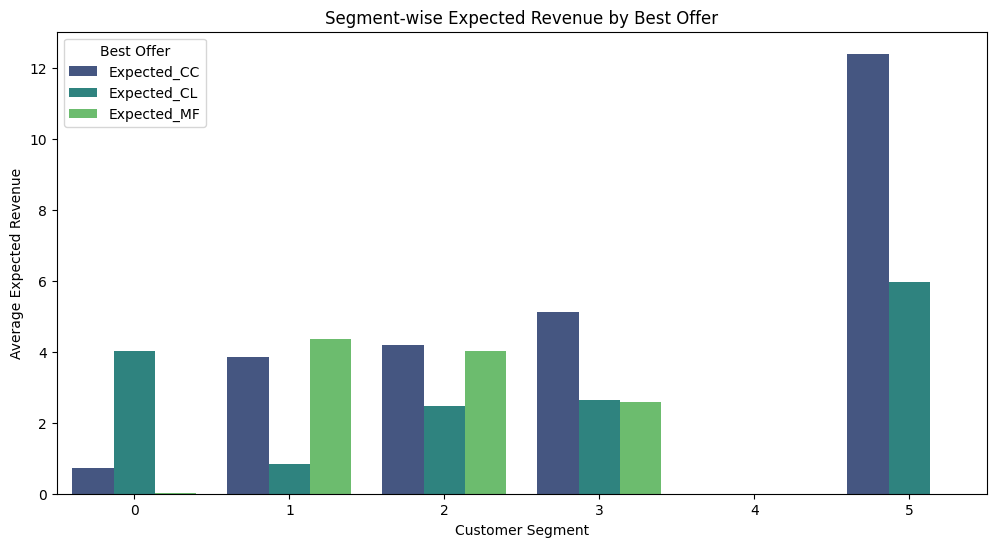

Segment 0:
- Top Offer: Expected_CL
- Average Expected Revenue: 3.63
- Characteristics: {'Age': 44.68421052631579, 'Tenure': 90.36842105263158, 'ActBal_CA': 1276.1912406015038, 'ActBal_SA': 762.7158458646618, 'ActBal_MF': 693.9432894736851, 'ActBal_OVD': 223.86748120300743, 'ActBal_CC': 65.72518796992483, 'ActBal_CL': 9674.287218045112, 'VolumeCred': 2617.301748120301, 'VolumeDeb': 2609.826879699248, 'VolumeDebCash_Card': 289.2857142857143, 'VolumeDebCashless_Card': 160.0087781954887, 'VolumeDeb_PaymentOrder': 417.09195488721804, 'TransactionsCred': 12.894736842105262, 'TransactionsDeb': 29.684210526315788, 'TransactionsDebCash_Card': 2.947368421052632, 'TransactionsDebCashless_Card': 5.842105263157895, 'Segment': 0}


Segment 1:
- Top Offer: Expected_CL
- Average Expected Revenue: 2.01
- Characteristics: {'Age': 59.531335149863764, 'Tenure': 86.3950953678474, 'ActBal_CA': 1615.4056938497472, 'ActBal_SA': 3346.005307512651, 'ActBal_MF': 3288.966544375246, 'ActBal_OVD': 40.6192234332424

In [30]:
# Analyze training data offer distribution and revenue contribution
offer_analysis = train_data.groupby(['Segment', 'Best_Offer'])[['Best_Expected_Revenue']].mean().reset_index()

# Visualize segment preferences
plt.figure(figsize=(12, 6))
sns.barplot(x='Segment', y='Best_Expected_Revenue', hue='Best_Offer', data=offer_analysis, palette='viridis')
plt.title("Segment-wise Expected Revenue by Best Offer")
plt.xlabel("Customer Segment")
plt.ylabel("Average Expected Revenue")
plt.legend(title="Best Offer")
plt.show()

# Print detailed explanations
for segment in segments['Segment']:
    segment_clients = train_data[train_data['Segment'] == segment]
    top_offer = segment_clients['Best_Offer'].value_counts().idxmax()
    avg_revenue = segment_clients['Best_Expected_Revenue'].mean()
    print(f"Segment {segment}:")
    print(f"- Top Offer: {top_offer}")
    print(f"- Average Expected Revenue: {avg_revenue:.2f}")
    print(f"- Characteristics: {segments.loc[segments['Segment'] == segment].to_dict('records')[0]}")
    print("\n")

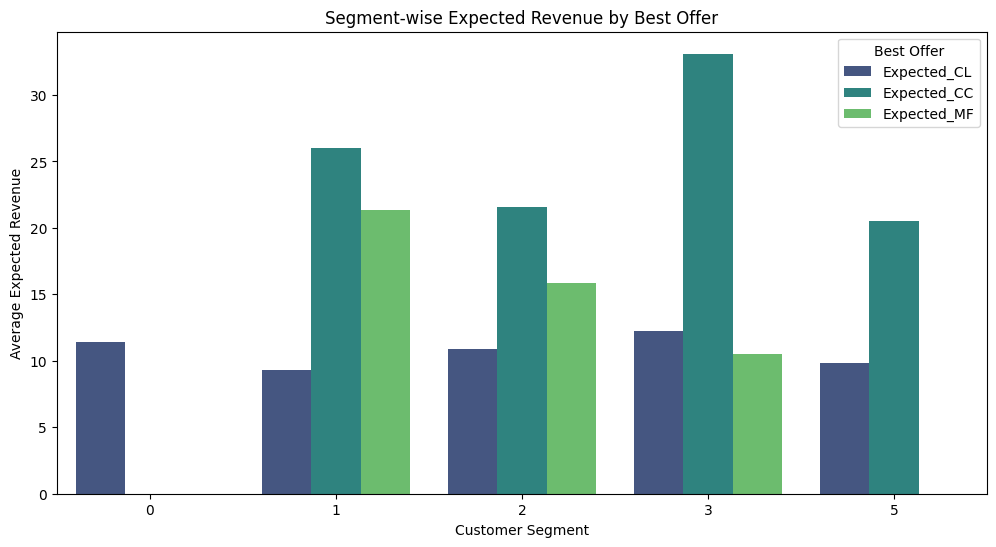

Segment 0:
- Top Offer: Expected_CL
- Average Expected Revenue: 11.43
- Characteristics: {'Age': 44.68421052631579, 'Tenure': 90.36842105263158, 'ActBal_CA': 1276.1912406015038, 'ActBal_SA': 762.7158458646618, 'ActBal_MF': 693.9432894736851, 'ActBal_OVD': 223.86748120300743, 'ActBal_CC': 65.72518796992483, 'ActBal_CL': 9674.287218045112, 'VolumeCred': 2617.301748120301, 'VolumeDeb': 2609.826879699248, 'VolumeDebCash_Card': 289.2857142857143, 'VolumeDebCashless_Card': 160.0087781954887, 'VolumeDeb_PaymentOrder': 417.09195488721804, 'TransactionsCred': 12.894736842105262, 'TransactionsDeb': 29.684210526315788, 'TransactionsDebCash_Card': 2.947368421052632, 'TransactionsDebCashless_Card': 5.842105263157895, 'Segment': 0}


Segment 1:
- Top Offer: Expected_MF
- Average Expected Revenue: 20.04
- Characteristics: {'Age': 59.531335149863764, 'Tenure': 86.3950953678474, 'ActBal_CA': 1615.4056938497472, 'ActBal_SA': 3346.005307512651, 'ActBal_MF': 3288.966544375246, 'ActBal_OVD': 40.61922343324

In [31]:
# Analyze why clients in target list were chosen
offer_analysis_target = targeted_clients.groupby(['Segment', 'Best_Offer'])[['Best_Expected_Revenue']].mean().reset_index()

# Visualize segment preferences
plt.figure(figsize=(12, 6))
sns.barplot(x='Segment', y='Best_Expected_Revenue', hue='Best_Offer', data=offer_analysis_target, palette='viridis')
plt.title("Segment-wise Expected Revenue by Best Offer")
plt.xlabel("Customer Segment")
plt.ylabel("Average Expected Revenue")
plt.legend(title="Best Offer")
plt.show()

# Print detailed explanations
for segment in segments['Segment']:
    segment_clients = targeted_clients[targeted_clients['Segment'] == segment]
    # skip 0 length segments i.e. segment 4 not present in target clients here 
    n_clients = len(segment_clients)
    if n_clients == 0:
        continue
    top_offer = segment_clients['Best_Offer'].value_counts().idxmax()
    avg_revenue = segment_clients['Best_Expected_Revenue'].mean()
    print(f"Segment {segment}:")
    print(f"- Top Offer: {top_offer}")
    print(f"- Average Expected Revenue: {avg_revenue:.2f}")
    print(f"- Characteristics: {segments.loc[segments['Segment'] == segment].to_dict('records')[0]}")
    print("\n")

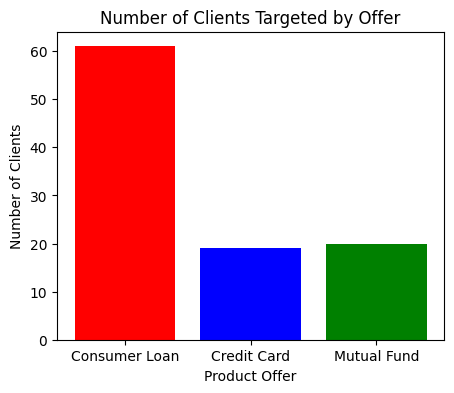

In [32]:
# Number of clients per offer
offer_counts = [
    targeted_clients['Chosen_CL'].sum(), 
    targeted_clients['Chosen_CC'].sum(), 
    targeted_clients['Chosen_MF'].sum()
]
offer_names = ['Consumer Loan', 'Credit Card', 'Mutual Fund']

plt.figure(figsize=(5, 4))
plt.bar(offer_names, offer_counts, color=['red', 'blue', 'green'])
plt.title("Number of Clients Targeted by Offer")
plt.xlabel("Product Offer")
plt.ylabel("Number of Clients")
plt.show()

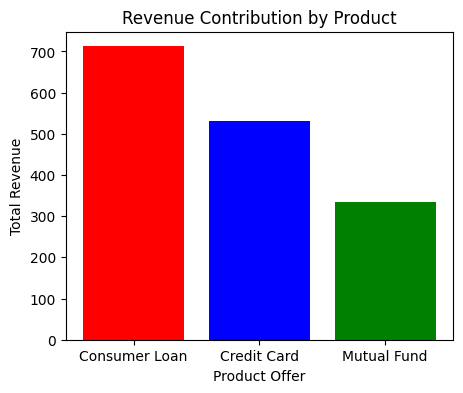

In [33]:
# Revenue Contribution by Product
revenues = [
    (targeted_clients['Expected_CL'] * targeted_clients['Chosen_CL']).sum(),
    (targeted_clients['Expected_CC'] * targeted_clients['Chosen_CC']).sum(),
    (targeted_clients['Expected_MF'] * targeted_clients['Chosen_MF']).sum()
]

plt.figure(figsize=(5, 4))
plt.bar(offer_names, revenues, color=['red', 'blue', 'green'])
plt.title("Revenue Contribution by Product")
plt.xlabel("Product Offer")
plt.ylabel("Total Revenue")
plt.show()

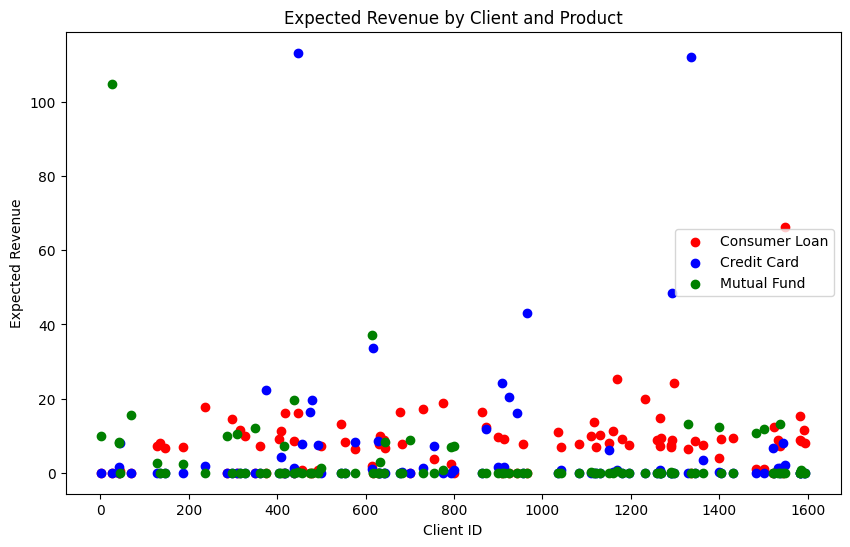

In [34]:
# Expected revenue per client by product
plt.figure(figsize=(10, 6))
plt.scatter(targeted_clients['Client'], targeted_clients['Expected_CL'], color='red', label='Consumer Loan')
plt.scatter(targeted_clients['Client'], targeted_clients['Expected_CC'], color='blue', label='Credit Card')
plt.scatter(targeted_clients['Client'], targeted_clients['Expected_MF'], color='green', label='Mutual Fund')
plt.title("Expected Revenue by Client and Product")
plt.xlabel("Client ID")
plt.ylabel("Expected Revenue")
plt.legend()
plt.show()

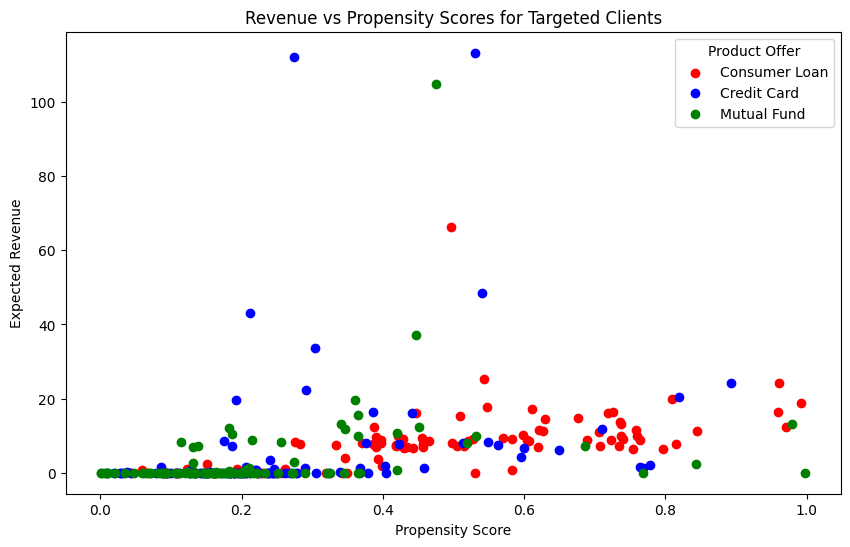

In [35]:
# Revenue vs Propensity Scores for Targeted Clients
plt.figure(figsize=(10, 6))
plt.scatter(targeted_clients['Prob_CL'], targeted_clients['Expected_CL'], color='red', label='Consumer Loan')
plt.scatter(targeted_clients['Prob_CC'], targeted_clients['Expected_CC'], color='blue', label='Credit Card')
plt.scatter(targeted_clients['Prob_MF'], targeted_clients['Expected_MF'], color='green', label='Mutual Fund')
plt.title("Revenue vs Propensity Scores for Targeted Clients")
plt.xlabel("Propensity Score")
plt.ylabel("Expected Revenue")
plt.legend(title="Product Offer")
plt.show()

## 7. Additional Analysis

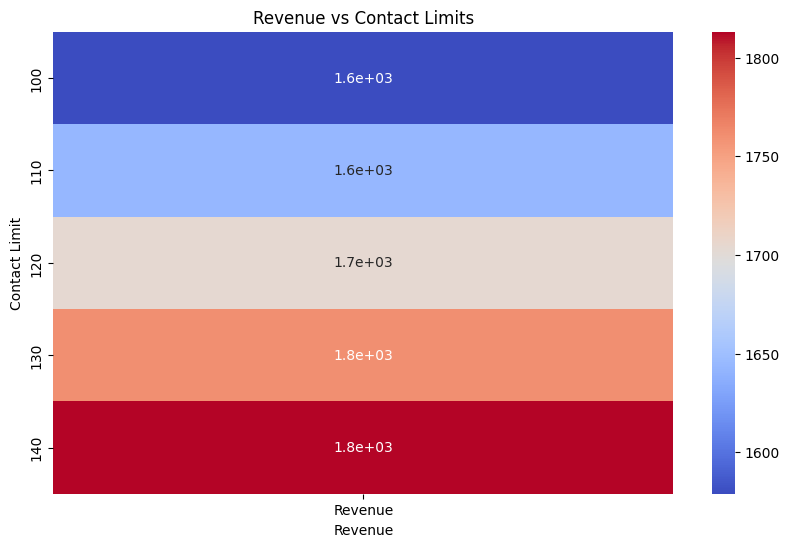

In [36]:
contact_limits = range(100, 150, 10)  # Example: contact limits from 100 to 150
revenues = []

# Linear programming formulation for revenue maximization under given constrains
from scipy.optimize import linprog

# Solve the optimization problem
for limit in contact_limits:
    # Re-run LP model with varying contact limits
    # Objective: Flatten all expected revenues into a single array
    revenue_CL = train_data['Expected_CL']
    revenue_CC = train_data['Expected_CC']
    revenue_MF = train_data['Expected_MF']
    c = -np.concatenate([revenue_CL, revenue_CC, revenue_MF])  # Negate for maximization (linprog minimizes by default)

    # Number of clients
    n_clients = len(train_data)

    # Constraints
    # 1. Contact limit: At most 100 clients can be targeted
    A_contact = np.concatenate([np.ones(n_clients), np.ones(n_clients), np.ones(n_clients)])  # 1 for all decision variables
    A_ub = [A_contact]  # Upper-bound constraint matrix
    b_ub = [limit]  # Contact limit

    # 2. Single offer per client: Each client receives at most one offer
    A_single_offer = np.zeros((n_clients, 3 * n_clients))
    for i in range(n_clients):
        A_single_offer[i, i] = 1  # Consumer Loan decision variable for client i
        A_single_offer[i, i + n_clients] = 1  # Credit Card decision variable for client i
        A_single_offer[i, i + 2 * n_clients] = 1  # Mutual Fund decision variable for client i
    b_single_offer = np.ones(n_clients)  # Each client can have at most one offer

    # Combine all constraints
    A_ub = np.vstack([A_ub, A_single_offer])
    b_ub = np.concatenate([b_ub, b_single_offer])

    # Bounds: Decision variables must be between 0 and 1 (binary approximation)
    x_bounds = [(0, 1)] * (3 * n_clients)

    result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_bounds, method="highs")  # Use the `highs` method for better performance
    revenues.append(-result.fun)

# Heatmap visualization
plt.figure(figsize=(10, 6))
sns.heatmap(np.array(revenues).reshape(-1, 1), annot=True, cmap='coolwarm', xticklabels=['Revenue'], yticklabels=contact_limits)
plt.title("Revenue vs Contact Limits")
plt.xlabel("Revenue")
plt.ylabel("Contact Limit")
plt.show()

In [37]:
# Example: Combine propensity scores for all models into a single DataFrame
train_data['Prob_CL'] = model_cl.predict_proba(X_scaled)[:, 1]  # Consumer Loan probabilities
train_data['Prob_CC'] = model_cc.predict_proba(X_scaled)[:, 1]  # Credit Card probabilities
train_data['Prob_MF'] = model_mf.predict_proba(X_scaled)[:, 1]  # Mutual Fund probabilities

# Sort by propensities for each product
top_clients_cl = train_data.sort_values(by='Prob_CL', ascending=False).head(10)  # Top for Consumer Loan
top_clients_cc = train_data.sort_values(by='Prob_CC', ascending=False).head(10)  # Top for Credit Card
top_clients_mf = train_data.sort_values(by='Prob_MF', ascending=False).head(10)  # Top for Mutual Fund

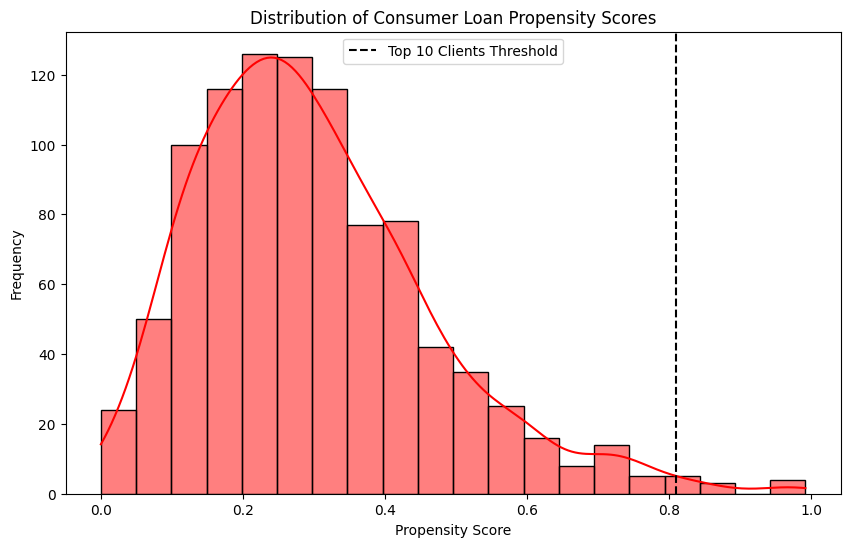

In [38]:
#distribution of Prob_CL across clients

plt.figure(figsize=(10, 6))
sns.histplot(train_data['Prob_CL'], bins=20, kde=True, color='red')
plt.title("Distribution of Consumer Loan Propensity Scores")
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.axvline(top_clients_cl['Prob_CL'].min(), color='black', linestyle='--', label="Top 10 Clients Threshold")
plt.legend()
plt.show()

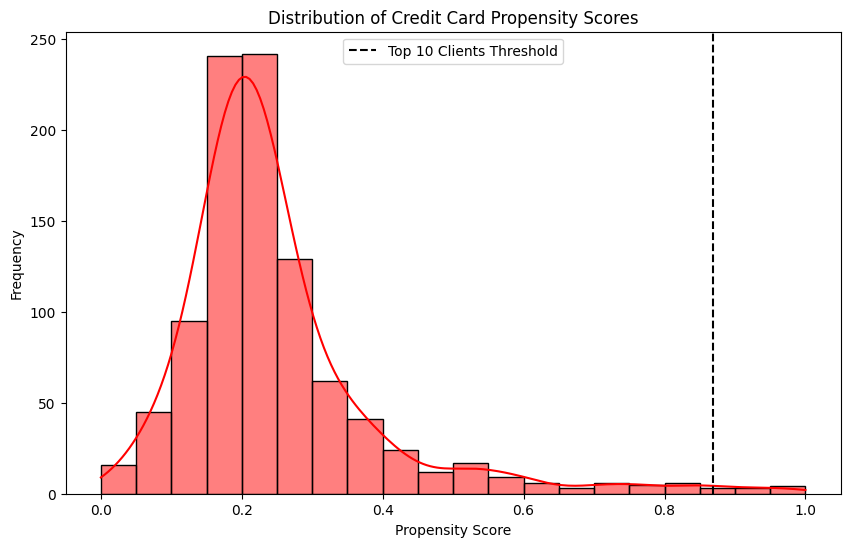

In [39]:
#distribution of Prob_CC across clients

plt.figure(figsize=(10, 6))
sns.histplot(train_data['Prob_CC'], bins=20, kde=True, color='red')
plt.title("Distribution of Credit Card Propensity Scores")
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.axvline(top_clients_cc['Prob_CC'].min(), color='black', linestyle='--', label="Top 10 Clients Threshold")
plt.legend()
plt.show()

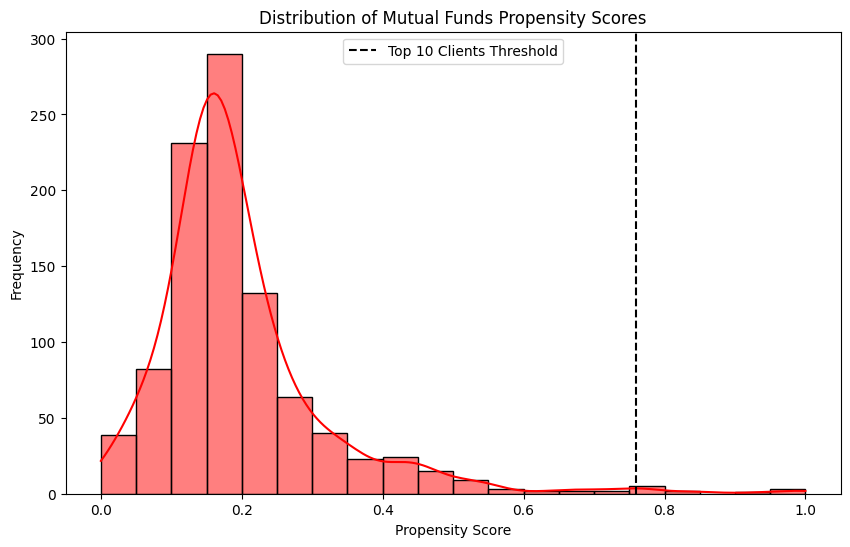

In [40]:
#distribution of Prob_MF across clients

plt.figure(figsize=(10, 6))
sns.histplot(train_data['Prob_MF'], bins=20, kde=True, color='red')
plt.title("Distribution of Mutual Funds Propensity Scores")
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.axvline(top_clients_mf['Prob_MF'].min(), color='black', linestyle='--', label="Top 10 Clients Threshold")
plt.legend()
plt.show()

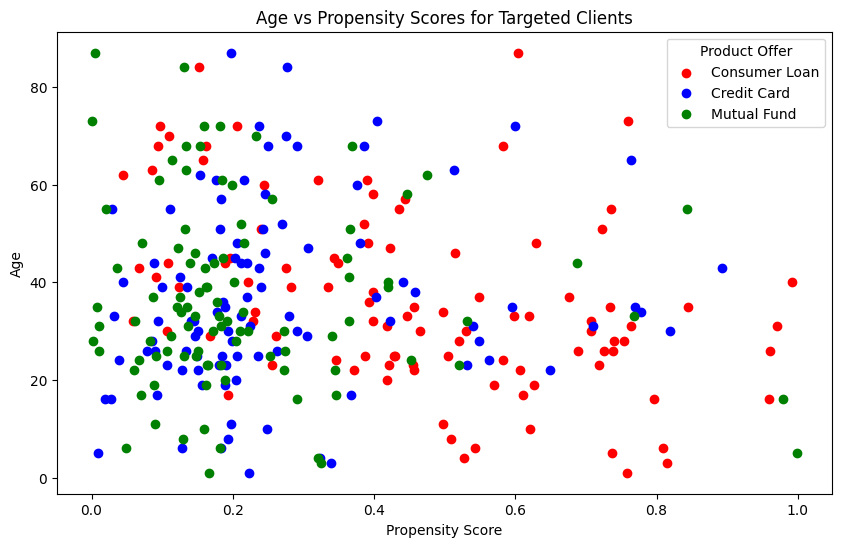

In [41]:
# Age vs Propensity Scores for Targeted Clients
plt.figure(figsize=(10, 6))
plt.scatter(targeted_clients['Prob_CL'], targeted_clients['Age'], color='red', label='Consumer Loan')
plt.scatter(targeted_clients['Prob_CC'], targeted_clients['Age'], color='blue', label='Credit Card')
plt.scatter(targeted_clients['Prob_MF'], targeted_clients['Age'], color='green', label='Mutual Fund')
plt.title("Age vs Propensity Scores for Targeted Clients")
plt.xlabel("Propensity Score")
plt.ylabel("Age")
plt.legend(title="Product Offer")
plt.show()